# Calorimeter Energy Study (v2)

# 0. Imports

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from scipy.stats import norm
from scipy.optimize import curve_fit
# from scipy.interpolate import UnivariateSpline

from datetime import date
from datetime import datetime

import time
import os

---
# 1. Helper Functions

## 1.1. Load QDC and TDC from Text File
- `load_TQDC(finPath)`

Takes a formatted text file of calorimeter data and returns 3 data products:
- `QDC`/`TDC`: An n x 8 x 8 array for QDC and TDC values, formatted `QDC[event_index][x_coord][y_coord]`
- `ogEventNums`: An array where `ogEventNums[event_index]` contains the original event number in the uncut run
    - This accomodates input files that already have some PID cuts applied causing event numbers to have gaps, such as filtering only for electron events

In [2]:
def load_TQDC(finPath):
    # basePath = "/media/sf_data/"
    # basePath = r'/media/eris/Sync1/sync/01_Research/MUSE/data'

    # load data from file
    # fin = os.path.join(basePath, finPath)
    fin = finPath
    t0 = time.time()
    raw_data = np.loadtxt(fin, skiprows = 5)
    t1 = time.time()
    print(f"Data file read in {t1-t0:.2f} seconds.")
    # return raw_data

    
    # initialize formatted data array
    num_events = raw_data.shape[0]
    print(f'There are {num_events} events')
    TDC = np.zeros((num_events, 8, 8), dtype=float)
    QDC = np.zeros((num_events, 8, 8), dtype=float)
    ogEventNums = np.zeros((num_events), dtype=int)
    
    
    # format data to [event#][x][y]
    t0 = time.time()
    i_event = -1

    
    for event in raw_data:
        i_event += 1 
        for x in range(8):
            # # this method preserves the original event number, but doesn't work when events aren't one by one
            # TDC [ np.int_(event[0]) ] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            # QDC [ np.int_(event[0]) ] [x] [:] = event[16*x+2 : 16*x+17 : 2]
            
            TDC [i_event] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            QDC [i_event] [x] [:] = event[16*x+2 : 16*x+17 : 2] 
            ogEventNums [i_event] = event[0]
            
    t1 = time.time()
    print(f"Data file formatted to array in {t1-t0:.2f} seconds.")
    
    return TDC, QDC, ogEventNums

## 1.2. Event Display
- `plotEvent(raw_data, event_num)`

In [3]:
colormap = 'magma'

def plotEvent(raw_data, event_num):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Plots an 8x8 histogram for the event
    '''
    
    TDC, QDC, ogEventNums = raw_data[:]
    
    ## 1. Plot Setup
    fig, (QAx, TAx) = plt.subplots(nrows=1, ncols=2, figsize= (13,5))#(11,4))
    plt.title(f'QDC for Event #{ogEventNums[event_num]}')

    ## 2. Plot QDC
    
    ## 2.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log10(np.where(QDC[event_num] <= 0, 0.01, QDC[event_num]))
    
    ## 2.2. Set flexible* max value for colorbar (*if the max qdc of this event is greater than the preset value, then use the actual max qdc value)
        # To cancel this effect, just set the preset value to be -1
                                                                                        # Format flexible vmax here
    presetMaxQDC = 3.5                                                                    
    if np.amax(thisFrame) > presetMaxQDC:
        this_vmax = np.amax(thisFrame)
    else:
        this_vmax = presetMaxQDC

    ## 2.3. Plot everything
    
    QPlot = QAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=this_vmax) # make sure to transpose frame for imshow
    
    QAx.set_title(f'QDC for Event #{ogEventNums[event_num]}')
    QAx.invert_yaxis()
    QAx.set_xticks(np.arange(0,8))
    Qcbar = plt.colorbar(QPlot, ax=QAx)
    Qcbar.set_label(r'QDC Counts ($\log_{10}$)', y=0.75)
    QAx.set_xlabel('X-coordinate of Bar')
    QAx.set_ylabel('Y-coordinate of Bar')
    # cbar.ax.tick_params()
   
    ## 2.4. Show QDC values in each square
    for x in range(8):
        for y in range(8):
            text = QAx.text(x, y, round(QDC[event_num][x][y],1), ha='center', va='center', color='w')
    
    ## 3. Plot TDC
    
    ## 3.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log(np.where(TDC[event_num] <= 0, 0.01, TDC[event_num]))
    
    ## 3.2. Plot everything 
    
    TPlot = TAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=5) # make sure to transpose frame for imshow
    
    TAx.set_title(f'TDC for Event #{ogEventNums[event_num]}')
    TAx.invert_yaxis()
    TAx.set_xticks(np.arange(0,8))
    Tcbar = plt.colorbar(TPlot, ax=TAx)
    Tcbar.set_label(r'TDC Counts ($\log_{10}$)', y=0.75)
    TAx.set_xlabel('X-coordinate of Bar')
    TAx.set_ylabel('Y-coordinate of Bar')
    
    ## 3.3. Show TDC values in each square
    for x in range(8):
        for y in range(8):
            if TDC[event_num][x][y] > 0.1:
                text = TAx.text(x, y, round(TDC[event_num][x][y],1), ha='center', va='center', color='w')

    
    fig.tight_layout()
    plt.show()
    return

## 1.3. Energy Sums
- `Esum1(raw_data, event_num, showStats=False, showEvent=False)`
- `Esum1_forall(raw_data)`
- `Esum2(raw_data, event_num, showStats=False, showHits=False)`
- `Esum2_forall(raw_data)`

In [4]:
def Esum1(raw_data, event_num, showStats=False, showEvent=False):
    '''
    Takes an 8x8 array of QDC values, finds the maximum value, and returns the sum of the max value + 8 surrounding values
    '''
    
    # Initial values/params
    _, QDC, ogEventNums = raw_data[:]
    frame = QDC[event_num]
    
    maxVal = np.amax(frame)
    maxPos = np.where(maxVal == frame)
    max_x = maxPos[0][0]
    max_y = maxPos[1][0]
    
    # Sum surrounding 8 voxels
    
    Esum = 0
    threshold = 0 # QDC values above this threshold will be added to the total Esum
    
    maxVal2 = 0
    E_total = 0
    
    for x in range(8):
        for y in range(8):
            if frame[x][y] >= threshold:
                E_total += frame[x][y]
            
            if abs(x-max_x) <= 1 and abs(y-max_y) <= 1 and frame[x][y] >= threshold:
                Esum += frame[x][y]
                
                if (x,y)!=(max_x,max_y) and frame[x][y] > maxVal2:
                    maxVal2 = frame[x][y]
                
    # Verbose output
    
    # avoid using this, it conflicts with showEvent functionality of esum2
    if showEvent: 
        plotEvent(raw_data,event_num)
        
    if showStats:
        print()
        print('******')
        print(f'{Esum:.2f}            = Energy sum (sum nonzero QDC values in max bar + 8 surrounding.')
        print('******')
        print()
        print(f'{maxVal:.2f} @ ({max_x},{max_y})    = Max QDC value @ (bar coordinate).')
        print()
        print(f'{maxVal / Esum * 100:.2f}%            = Percent of energy sum deposited into central bar.')
        print(f'{(maxVal+maxVal2) / Esum * 100:.2f}%            = Percent of energy sum deposited into central bar + 2nd highest QDC bar.')
        print(f'{Esum / E_total * 100:.2f}%            = Percent of total energy captured by energy sum.')
        print()
        print(f'Event #{ogEventNums[event_num]} (index {event_num})')

    
        # print(f'Sum of nonzero QDC values in 8 bars surrounding max bar          {Esum:.2f}')
        # print(f'Max QDC value and coordinate of bar                              {maxVal:.2f} @ ({max_x},{max_y})')
        # print(f'%Energy sum captured by central bar                              {maxVal / Esum * 100:.2f}%')
        # print(f'%Energy sum captured by central bar + 2nd highest QDC bar        {(maxVal+maxVal2) / Esum * 100:.2f}%.')
    
    return Esum #, [max_x, max_y]


def Esum1_forall(raw_data):
    # preallocate
    num_events = np.shape(raw_data[0]) [0]
    all_Esums = np.zeros(num_events, dtype=float)

    # calc values
    for event_num in range(num_events):
        all_Esums[event_num] = Esum1(raw_data, event_num)
        
    return all_Esums


################################################################################################################################################

def Esum2(raw_data, event_num, showStats=False, showHits=False):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Finds the total energy deposited by the scattering event by summing outliers, then subtracting the average non-outlier and subtracting it as noise
    '''
    
    _, QDC, ogEventNums = raw_data[:]
    
    ## 1. Find outliers and add to Esum
    frame = QDC[event_num]
    # frame = np.where(raw_data[1][event_num] < 0, 0, raw_data[1][event_num]) # If you replace negative values with 0, you tend to capture more voxels. Not sure if this is a good thing.
    
    q3, q1 = np.percentile(frame, [75, 25])
    iqr = q3 - q1
    outliers = np.where(frame > q3+1.5*iqr, True, False)
    
    Esum_noisy = np.sum(frame[outliers])
    
    ## 2. Find and subtract noise
    frame_zeroed = np.where(QDC[event_num] < 0, 0, QDC[event_num])
    avgNoise = np.average(frame_zeroed[np.invert(outliers)])
    
    numHits = np.sum(outliers)
    
    Esum = Esum_noisy - avgNoise * numHits

    # if Esum_noisy < 10:
    #     Esum_noisy, Esum = 0, 0
    
    
    # Verbose output
        
    if showStats:
        print()
        print('******')        
        print(f'{Esum:.2f}            = Energy sum (sum QDC values for \"hit\" bars)')
        print('******')
        print()
        print(f'{Esum_noisy:.2f}            = Noise corrected energy sum (subtract avg QDC of non-hit bars for each hit bar)')
        print()
        print(f'{ (Esum_noisy-Esum) / Esum:.2f}%             = Percent noise adjustment.')
        print(f'{Esum / (np.sum(frame_zeroed)) * 100:.2f}%            = Percent of total energy captured by energy sum.')
        print()
        print(f'Event #{ogEventNums[event_num]} (index {event_num})')

        
    if showHits:
        fig, ax = plt.subplots(figsize=(12,4.5))
        ax.imshow(outliers.T, 'magma')
        ax.invert_yaxis()
        ax.set_title(f'QDC \"Hits\" for Event #{ogEventNums[event_num]}')
        ax.set_xlabel('X-coordinate of Bar')
        ax.set_ylabel('Y-coordinate of Bar')
        plt.show()

        

    return Esum, Esum_noisy


def Esum2_forall(raw_data):
    # preallocate
    num_events = np.shape(raw_data[0]) [0]
    all_Esums = np.zeros(num_events, dtype=float)

    # calc values
    for event_num in range(num_events):
        all_Esums[event_num] = Esum2(raw_data, event_num)[0] # 0 for noise corrected, 1 for raw
        
    return all_Esums

## 1.4. Double Hit Events
- `removeDoubleHits(raw_data, TDC_threshold=1.0)`

In [5]:
def removeDoubleHits(raw_data, TDC_threshold=1.0):
    TDC_cut = []
    QDC_cut = []
    ogEventNum_cut = []
    
    TDC, QDC, ogEventNum = raw_data[:]
    total_num_events = np.shape(TDC)[0]
    num_double_events = 0

    for event_num in range(total_num_events):
        frame = TDC[event_num]

        maxVal = np.amax(frame)

        minVal = 0
        for x in range(8):
            for y in range(8):
                if frame[x][y] > minVal and frame[x][y] != maxVal:
                    minVal = frame[x][y]

        if maxVal - minVal > TDC_threshold and minVal > 1: # if this event has two hits
            num_double_events += 1
        else:
            TDC_cut.append(TDC[event_num])
            QDC_cut.append(QDC[event_num])
            ogEventNum_cut.append(ogEventNum[event_num])
    
    return [TDC_cut,QDC_cut,ogEventNum_cut]

## 1.5. Make Plots
- `makeIndividualPlots(arr, title)`
- `makeOverlaidPlots(arr1, arr2, label1, label2, title, path)`

In [6]:
num_bins=200

def makeIndividualPlots(arr, title, path):
    # arr, title = Esum1_all, f'Esum1 (raw)\nRun {i_run}'
    
    # cheats lulw
    if i_run <= 12358:
        arr = np.where(arr<500, 0, arr)
        arr = arr[arr != 0]
    elif i_run == 12359:
        arr = np.where(arr<400, 0, arr)
        arr = arr[arr != 0]
    

    fig, axs = plt.subplots(figsize=(10,7))

    counts, bins, _ = axs.hist(arr, bins=num_bins)

    # bin_size = bins[1]-bins[0]
    x = np.linspace(bins[0],bins[-1],len(bins)-1) 

    # max_esum = bins[np.where(counts == counts.max())][0]
    max_counts = counts[np.where(counts == counts.max())][0]

    (mu, sigma) = norm.fit(arr)

    def gauss(x,amp,mu,sigma):
        return amp*np.exp(-(x-mu)**2/(2*sigma**2))

    popt,pcov = curve_fit(gauss,x,counts,p0=(max_counts,mu,sigma))

    y = gauss(x, popt[0],popt[1],popt[2])

    plt.plot(x,y,'r',linewidth=3)

    # axs.set_yscale('log')
    axs.set_title(title)
    axs.set_xlabel('Energy Sum (QDC)')
    axs.set_ylabel('Counts')

    axs.legend(
        [f'Mean     = {mu:.2f} \nStd Dev = {sigma:.2f} \nEntries  = {len(arr)}'], 
        prop={'size': 12}
    )

    fig.savefig(path)
    # plt.show()
    plt.close(fig)

    return mu, sigma


def makeOverlaidPlots(arr1, arr2, label1, label2, title, path):
    
    # get normalization factors for histograms

    (counts1, bins1) = np.histogram(arr1, bins=num_bins)
    max_edep1 = counts1[np.where(counts1 == counts1.max())][0]
    factor1 = 1/max_edep1
    (counts2, bins2) = np.histogram(arr2, bins=num_bins)
    max_edep2 = counts2[np.where(counts2 == counts2.max())][0]
    factor2 = 1/max_edep2

    # plots
    fig, axs = plt.subplots(figsize=(10,7))

    axs.hist(bins1[:-1],
             bins = bins1,
             alpha=0.5, 
             weights=factor1*counts1,
             label=label1)
    axs.hist(bins2[:-1],
             bins = bins2,
             alpha=0.5, 
             weights=factor2*counts2,
             label=label2)


    # axs.set_yscale('log')
    axs.set_title(title)
    axs.set_xlabel('Energy Sum (QDC)')
    axs.set_ylabel('Counts (normalized)')
    axs.legend(loc='upper right')


    fig.savefig(path)
    # plt.show()
    plt.close(fig)
    
    
    return

---
# 2. Energy Study

### Verbose Run Dictionary

---
# 3. Momentum v Channel

In [7]:
run = {12354: {'filename': 'run12354_calo_qdc_tdc.txt', 'momentum': 230, 'Esum1': {'raw': {'entries': 45477, 'mean': 1334.1163125154496, 'stddev': 207.88287114609957}, 'DHcut': {'entries': 20934, 'mean': 1310.9872115385356, 'stddev': 199.49265140175686}}, 'Esum2': {'raw': {'entries': 45477, 'mean': 1387.563339760479, 'stddev': 217.99020933605203}, 'DHcut': {'entries': 20934, 'mean': 1352.986099827075, 'stddev': 204.74175260314954}}}, 12355: {'filename': 'run12355_calo_qdc_tdc.txt', 'momentum': 210, 'Esum1': {'raw': {'entries': 60848, 'mean': 1206.257261052662, 'stddev': 180.73349387520832}, 'DHcut': {'entries': 32240, 'mean': 1193.205658017287, 'stddev': 172.74813869691758}}, 'Esum2': {'raw': {'entries': 60848, 'mean': 1248.3874522479252, 'stddev': 182.8135602421019}, 'DHcut': {'entries': 32240, 'mean': 1226.8950911959544, 'stddev': 172.77235409758845}}}, 12356: {'filename': 'run12356_calo_qdc_tdc.txt', 'momentum': 190, 'Esum1': {'raw': {'entries': 92961, 'mean': 1083.2061051860742, 'stddev': 158.2863868005277}, 'DHcut': {'entries': 55363, 'mean': 1073.0030349667243, 'stddev': 152.64448334636083}}, 'Esum2': {'raw': {'entries': 92961, 'mean': 1117.229135498469, 'stddev': 156.12380324951732}, 'DHcut': {'entries': 55363, 'mean': 1101.7768379137456, 'stddev': 150.01182716017527}}}, 12357: {'filename': 'run12357_calo_qdc_tdc.txt', 'momentum': 170, 'Esum1': {'raw': {'entries': 157640, 'mean': 963.6221480058722, 'stddev': 144.7084126001648}, 'DHcut': {'entries': 96610, 'mean': 955.8704191767408, 'stddev': 139.82835305005008}}, 'Esum2': {'raw': {'entries': 157640, 'mean': 993.5067289028174, 'stddev': 142.59502269493925}, 'DHcut': {'entries': 96610, 'mean': 980.5132663829725, 'stddev': 137.20879348416918}}}, 12358: {'filename': 'run12358_calo_qdc_tdc.txt', 'momentum': 160, 'Esum1': {'raw': {'entries': 209621, 'mean': 904.5523046207736, 'stddev': 135.26501178426096}, 'DHcut': {'entries': 133635, 'mean': 897.3856202337739, 'stddev': 130.0908651559969}}, 'Esum2': {'raw': {'entries': 209621, 'mean': 931.1527537776416, 'stddev': 132.7884064394081}, 'DHcut': {'entries': 133635, 'mean': 919.4402541071688, 'stddev': 127.22668357789689}}}, 12359: {'filename': 'run12359_calo_qdc_tdc.txt', 'momentum': 150, 'Esum1': {'raw': {'entries': 261213, 'mean': 840.7084830767726, 'stddev': 132.01064936638184}, 'DHcut': {'entries': 172519, 'mean': 833.9927233074939, 'stddev': 128.10258145164156}}, 'Esum2': {'raw': {'entries': 261213, 'mean': 865.5660088183425, 'stddev': 129.15377439893845}, 'DHcut': {'entries': 172519, 'mean': 854.5288773574873, 'stddev': 125.20299317717607}}}, 12360: {'filename': 'run12360_calo_qdc_tdc.txt', 'momentum': 130, 'Esum1': {'raw': {'entries': 451338, 'mean': 715.4575230088759, 'stddev': 130.7648202410195}, 'DHcut': {'entries': 316275, 'mean': 707.50731588657, 'stddev': 130.06097091326174}}, 'Esum2': {'raw': {'entries': 451338, 'mean': 737.2321287602863, 'stddev': 126.70859942478636}, 'DHcut': {'entries': 316275, 'mean': 724.9689199703507, 'stddev': 125.91559407792975}}}, 12361: {'filename': 'run12361_calo_qdc_tdc.txt', 'momentum': 110, 'Esum1': {'raw': {'entries': 556585, 'mean': 597.2696265132729, 'stddev': 113.87535721272472}, 'DHcut': {'entries': 421334, 'mean': 589.5303150091139, 'stddev': 112.57009441513434}}, 'Esum2': {'raw': {'entries': 556585, 'mean': 614.5974751980131, 'stddev': 109.9004106105543}, 'DHcut': {'entries': 421334, 'mean': 603.6000555772977, 'stddev': 107.96276424092905}}}, 12362: {'filename': 'run12362_calo_qdc_tdc.txt', 'momentum': 90, 'Esum1': {'raw': {'entries': 564835, 'mean': 480.00546690213963, 'stddev': 98.51046496644196}, 'DHcut': {'entries': 471812, 'mean': 473.0894681437096, 'stddev': 97.05001322566585}}, 'Esum2': {'raw': {'entries': 564835, 'mean': 492.159268818577, 'stddev': 95.58496389596874}, 'DHcut': {'entries': 471812, 'mean': 483.18997818501873, 'stddev': 93.4386541327132}}}, 12363: {'filename': 'run12363_calo_qdc_tdc.txt', 'momentum': 70, 'Esum1': {'raw': {'entries': 517476, 'mean': 367.37074075303013, 'stddev': 79.96173694315554}, 'DHcut': {'entries': 477936, 'mean': 363.338655326299, 'stddev': 78.40024098619223}}, 'Esum2': {'raw': {'entries': 517476, 'mean': 373.8833767617078, 'stddev': 78.53382948964654}, 'DHcut': {'entries': 477936, 'mean': 368.91968695223096, 'stddev': 76.41621095985525}}}, 12364: {'filename': 'run12364_calo_qdc_tdc.txt', 'momentum': 50, 'Esum1': {'raw': {'entries': 230100, 'mean': 268.0278792967188, 'stddev': 58.87649970600277}, 'DHcut': {'entries': 225915, 'mean': 266.88582804054624, 'stddev': 58.03446885306163}}, 'Esum2': {'raw': {'entries': 230100, 'mean': 268.6924886437063, 'stddev': 58.60719993260163}, 'DHcut': {'entries': 225915, 'mean': 267.31178416736026, 'stddev': 57.451491726969685}}}}

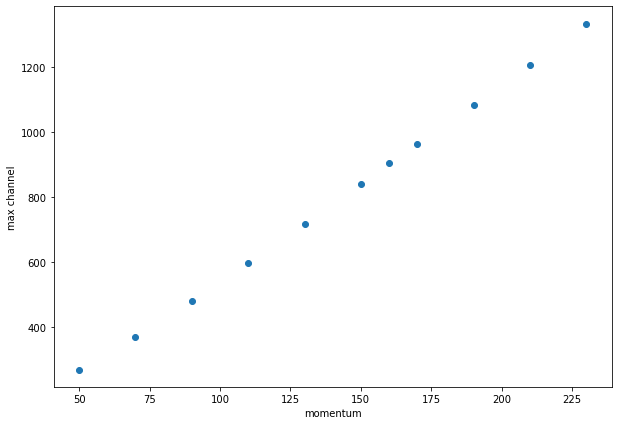

In [8]:
x = []
y = []

for i in run:
    x.append( run[i]['momentum'] )
    y.append( run[i]['Esum1']['raw']['mean'] )
    

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x,y)
ax.set_xlabel('momentum')
ax.set_ylabel('max channel')

plt.show(fig)

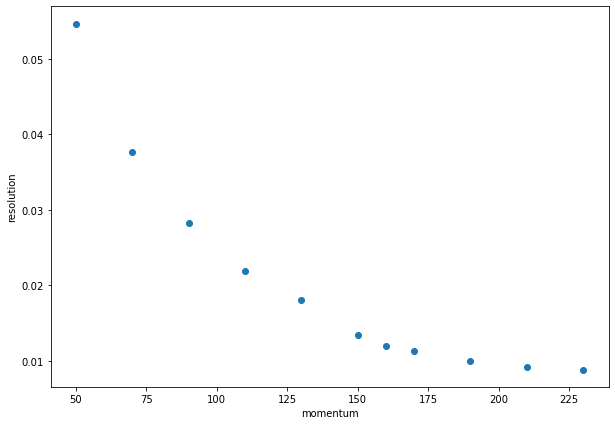

In [9]:
mass_electron = 0.51099895000 # rest mass in MeV/c^2
fig, ax = plt.subplots(figsize=(10,7))



x = []
y = []

sum_method = 'Esum1'
cut_method = 'DHcut'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )
    


ax.scatter(x,y)
ax.set_xlabel('momentum')
ax.set_ylabel('resolution')

plt.show(fig)



## Resolution = $\frac{2\sqrt{2\ln{2}} \ \cdot \ \sigma}{p^2+0.511^2}$

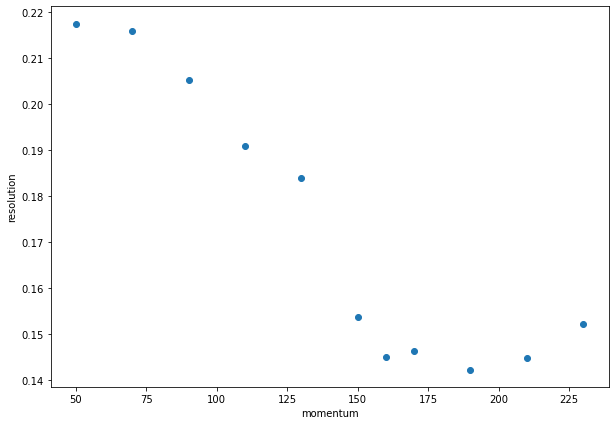

In [10]:
## mass_electron = 0.51099895000 # rest mass in MeV/c^2

x = []
y = []

sum_method = 'Esum1'
cut_method = 'DHcut'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    y.append( run[i][sum_method][cut_method]['stddev'] / run[i][sum_method][cut_method]['mean'] )
    

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x,y)
ax.set_xlabel('momentum')
ax.set_ylabel('resolution')

plt.show(fig)



# Comparisons

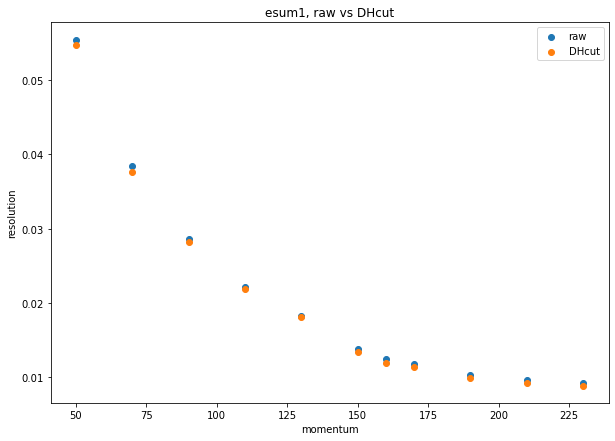

In [11]:
mass_electron = 0.51099895000 # rest mass in MeV/c^2
fig, ax = plt.subplots(figsize=(10,7))



x = []
y = []

sum_method = 'Esum1'
cut_method = 'raw'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )
    
ax.scatter(x,y, label='raw')


x = []
y = []

sum_method = 'Esum1'
cut_method = 'DHcut'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )
    
ax.scatter(x,y, label='DHcut')





ax.set_title('esum1, raw vs DHcut')
ax.set_xlabel('momentum')
ax.set_ylabel('resolution')
ax.legend(loc='upper right')



plt.show(fig)



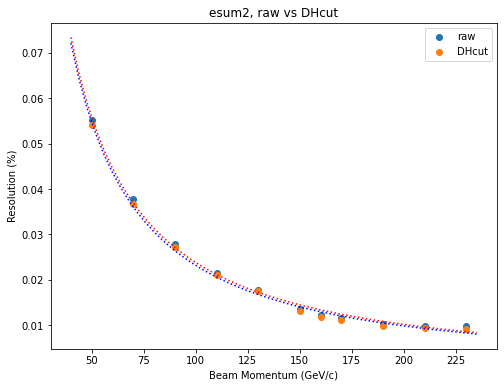

In [15]:
mass_electron = 0.51099895000 # rest mass in MeV/c^2
fig, ax = plt.subplots(figsize=(8,6))


# def fitter(x, a, b, c):
#     # e = np.sqrt(x**2 + mass_electron**2)
#     return np.sqrt((a**2)/x + b**2 + (c/x)**2)

def fitter(x, a, b):
    return a*x**-b




x = []
y = []

sum_method = 'Esum2'
cut_method = 'raw'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )

# x.reverse()
# y.reverse()

# noise = 1 + np.random.rand(len(y))*0.15
    
ax.scatter(x,y, label='raw')

# xlin = np.linspace(x[0],x[-1])
xlin = np.linspace(40,235)
optimizedParameters, pcov = curve_fit(fitter, x, y)
plt.plot(xlin, fitter(xlin, *optimizedParameters), ':r')


# s = UnivariateSpline(x, y, s=5)
# xlin = np.linspace(x[0],x[-1])
# ylin = s(xlin)
# plt.plot(xlin,ylin)




x = []
y = []

sum_method = 'Esum2'
cut_method = 'DHcut'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )
    
ax.scatter(x,y, label='DHcut')


xlin = np.linspace(40,235)
optimizedParameters, pcov = curve_fit(fitter, x, y)
plt.plot(xlin, fitter(xlin, *optimizedParameters), ':b')




ax.set_title('esum2, raw vs DHcut')
ax.set_xlabel('Beam Momentum (GeV/c)')
ax.set_ylabel('Resolution (%)')
ax.legend(loc='upper right')



plt.show(fig)
fig.savefig('./p_v_res.pdf')



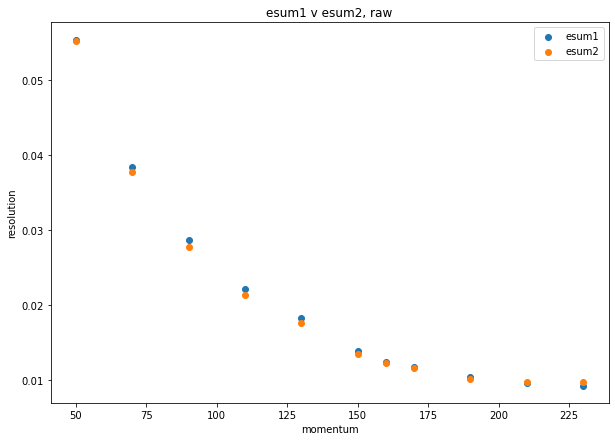

In [13]:
mass_electron = 0.51099895000 # rest mass in MeV/c^2
fig, ax = plt.subplots(figsize=(10,7))



x = []
y = []

sum_method = 'Esum1'
cut_method = 'raw'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )
    
ax.scatter(x,y, label='esum1')


x = []
y = []

sum_method = 'Esum2'
cut_method = 'raw'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )
    
ax.scatter(x,y, label='esum2')





ax.set_title('esum1 v esum2, raw')
ax.set_xlabel('momentum')
ax.set_ylabel('resolution')
ax.legend(loc='upper right')



plt.show(fig)



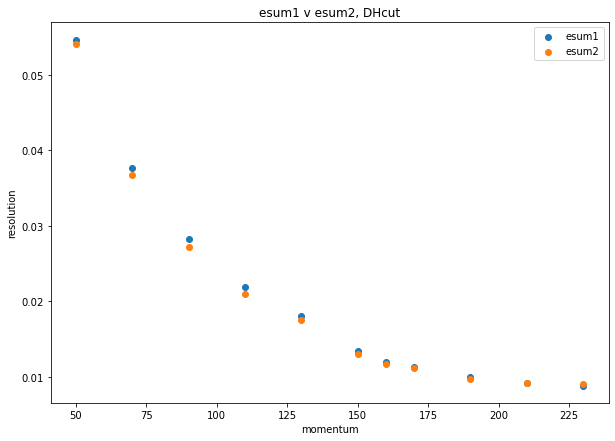

In [14]:
mass_electron = 0.51099895000 # rest mass in MeV/c^2
fig, ax = plt.subplots(figsize=(10,7))



x = []
y = []

sum_method = 'Esum1'
cut_method = 'DHcut'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )
    
ax.scatter(x,y, label='esum1')


x = []
y = []

sum_method = 'Esum2'
cut_method = 'DHcut'

for i in run:
    # print(run[i][sum_method][cut_method]['stddev'])
    x.append( run[i]['momentum'] )
    
    width = (2*np.sqrt(2*np.log(2))) * run[i][sum_method][cut_method]['stddev']
    resolution = width / (run[i]['momentum']**2 + mass_electron**2)
    y.append( resolution )
    
ax.scatter(x,y, label='esum2')





ax.set_title('esum1 v esum2, DHcut')
ax.set_xlabel('momentum')
ax.set_ylabel('resolution')
ax.legend(loc='upper right')



plt.show(fig)

